Research Question

What is the expected 5-year net financial outcome (post-graduation) for an individual choosing between a Registered Nursing (RN) degree and a Bachelor's in Electrical Engineering (EE), when the decision is modeled using a linear combination of discrete random variables representing acceptance probability, starting salary, student loan debt, annual living expenses, and transportation costs?

Simulation Description

Purpose:
This simulation estimates the expected 5-year net financial outcome for two career pathways, Registered Nursing (RN) and Electrical Engineering (EE) by modeling key financial factors as random variables. The outcome, total net income after five years, is expressed as a linear combination of discrete and continuous random variables representing salary, costs, debt, and other uncertainties.

Assumptions:
The simulation follows one individual who chooses either Nursing or Electrical Engineering as a career path.

Each student faces a random chance of program acceptance; if rejected, they take an alternative entry-level job with lower pay and no student debt.

If accepted, the student incurs student loan debt and receives a starting salary drawn from a normal distribution, which grows annually based on random raises and occasional promotions.

Each year, the individual experiences living expenses (rent, food, and transportation), modeled as random variables.

There is a small probability of temporary unemployment in any year, reducing annual income. Registered Nurses generally have higher employment opportunities, so their actual unemployment risk may be slightly lower than other careers.

Taxes are applied through a simplified effective tax rate that increases with salary level.

RN Post-Graduation Training: Some Registered Nursing programs require post-graduation orientation or supervised practice. This simulation reduces first-year net pay by $5,000 to reflect this, with all other financial parameters unchanged.

The model spans the first five years after graduation.

=== Summary (full simulated data) ===
                        career  trials  mean_net  median_net  p10_net  \
0  Electrical Engineering (EE)    2000  $167,769    $205,829  $13,557   
1                 Nursing (RN)    2000  $158,130    $183,041  $30,485   

   p90_net  mean_start  accept_rate_sim  
0 $305,724     $65,088               $1  
1 $239,758     $60,381               $1  


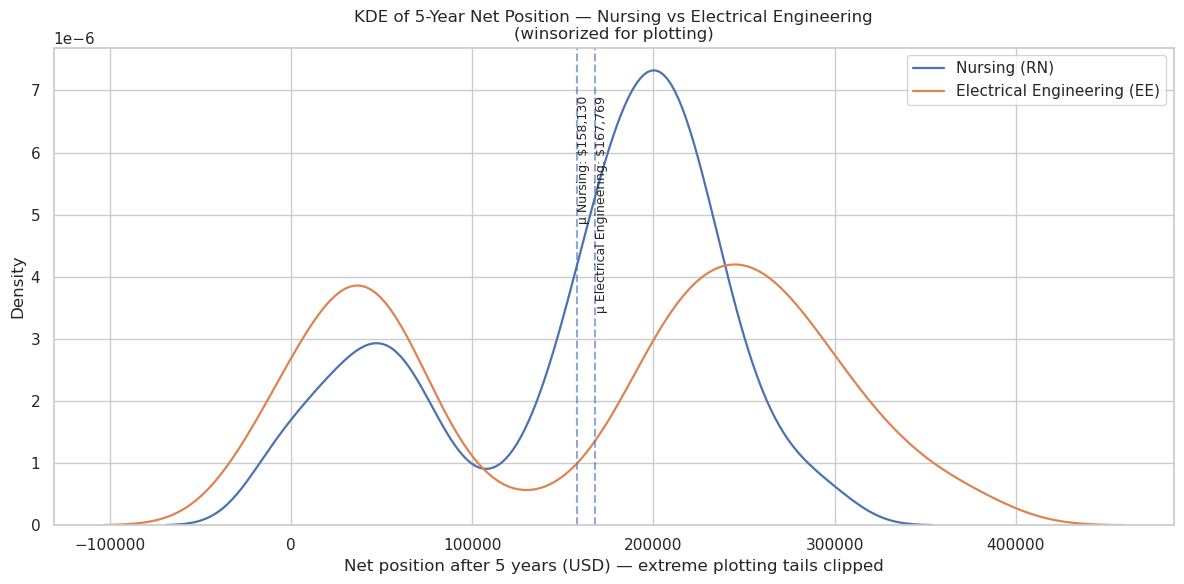

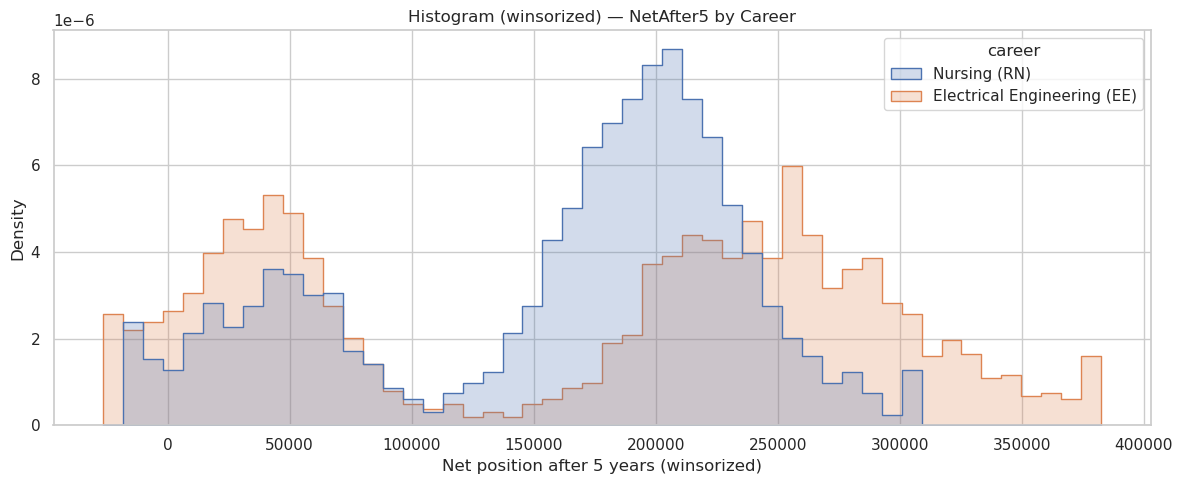


Saved CSVs: 'nursing_vs_ee_5yr_summary.csv' and 'nursing_vs_ee_5yr_trials.csv'


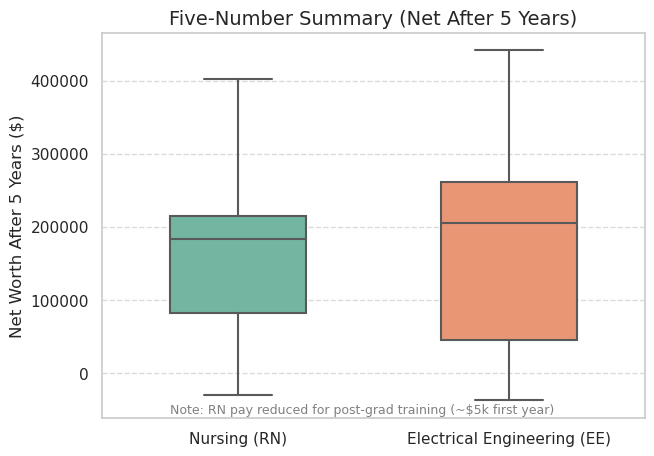


=== Five-Number Summary (Net After 5 Years) ===
                        career      min     25%      50%      75%      max
0  Electrical Engineering (EE) $-36,914 $46,120 $205,829 $261,468 $441,297
1                 Nursing (RN) $-29,913 $82,395 $183,041 $214,622 $401,909


In [26]:
# Nursing vs Electrical Engineering (5-year net)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
np.random.seed(2025)

# Simulation settings
n_trials = 2000    # >= 100 trials
years = 5
plot_winsor_pct = 1  # pct to clip for plotting only (remove extreme 1% tails)

# Career parameterization
careers = {
    "Nursing (RN)": {
        "accept_prob": 0.72,
        "start_salary_mean": 72000, "start_salary_std": 7000,
        "loan_mean": 25000, "loan_std": 8000,
        "growth_mean": 0.03, "growth_std": 0.01,
        "rent_mean": 13000, "food_mean": 4800, "transport_mean": 2200
    },
    "Electrical Engineering (EE)": {
        "accept_prob": 0.60,
        "start_salary_mean": 88000, "start_salary_std": 10000,
        "loan_mean": 34000, "loan_std": 10000,
        "growth_mean": 0.035, "growth_std": 0.015,
        "rent_mean": 15000, "food_mean": 5200, "transport_mean": 2800
    }
}

# Other model params
promotion_prob = 0.12
promotion_bump_mean, promotion_bump_std = 0.15, 0.05
unemp_prob_ee = 0.02        # EE unemployment probability
unemp_prob_nursing = 0.015  # RN unemployment probability (lower for higher job security)
unemp_months_mu, unemp_months_sigma = 2.0, 1.2
job_search_cost_mu, job_search_cost_sigma = 1500, 800

def effective_tax_rate(sal):
    if sal < 40000: return 0.12
    elif sal < 90000: return 0.18
    elif sal < 150000: return 0.22
    else: return 0.28

def alternative_job_salary():
    return max(18000, np.random.normal(30000, 7000))

# Single-trial simulator for a chosen career
def simulate_one(career_name, params):
    accepted = np.random.rand() < params["accept_prob"]
    if accepted:
        start_salary = max(0.0, np.random.normal(params["start_salary_mean"], params["start_salary_std"]))
        loan = max(0.0, np.random.normal(params["loan_mean"], params["loan_std"]))
    else:
        start_salary = alternative_job_salary()
        loan = 0.0

    # initial costs: loan principal (if any) and job search cost
    job_search = max(0.0, np.random.normal(job_search_cost_mu, job_search_cost_sigma))
    net = -loan - job_search

    salary = start_salary
    for yr in range(years):
        # base growth + possible promotion bump
        growth = np.random.normal(params["growth_mean"], params["growth_std"])
        if np.random.rand() < promotion_prob:
            growth += np.random.normal(promotion_bump_mean, promotion_bump_std)
        salary = max(0.0, salary * (1 + growth))

        # unemployment reduces paid months this year
        unemp_prob = unemp_prob_nursing if "Nursing" in career_name else unemp_prob_ee
        if np.random.rand() < unemp_prob:
            months_unemp = np.clip(np.random.normal(unemp_months_mu, unemp_months_sigma), 0, 12)
            salary_year = salary * (1 - months_unemp / 12.0)
        else:
            salary_year = salary

        tax_rate = effective_tax_rate(salary_year)
        after_tax = salary_year * (1 - tax_rate)

        # living costs
        rent = max(0.0, np.random.normal(params["rent_mean"], 2000))
        food = max(0.0, np.random.normal(params["food_mean"], 800))
        transport = max(0.0, np.random.normal(params["transport_mean"], 600))

        year_net = after_tax - (rent + food + transport)

        # RN post-grad adjustment (~$5k reduction in first year)
        if "Nursing" in career_name and yr == 0:
            year_net -= 5000

        net += year_net

    return net, start_salary, accepted

# Run trials for each career
rows = []
for career_name, params in careers.items():
    for _ in range(n_trials):
        net5, start_sal, accepted = simulate_one(career_name, params)
        rows.append({
            "career": career_name,
            "net_after_5yrs": net5,
            "start_salary": start_sal,
            "accepted": accepted
        })

df = pd.DataFrame(rows)

# Summary statistics (full data)
summary = df.groupby("career").agg(
    trials=("net_after_5yrs","count"),
    mean_net=("net_after_5yrs","mean"),
    median_net=("net_after_5yrs","median"),
    p10_net=("net_after_5yrs", lambda x: np.percentile(x,10)),
    p90_net=("net_after_5yrs", lambda x: np.percentile(x,90)),
    mean_start=("start_salary","mean"),
    accept_rate_sim=("accepted","mean")
).reset_index()

pd.set_option('display.float_format', lambda x: f"${x:,.0f}")
print("=== Summary (full simulated data) ===")
print(summary)

# Winsorize for plotting
def winsorize(arr, pct):
    lo = np.percentile(arr, pct)
    hi = np.percentile(arr, 100-pct)
    return np.clip(arr, lo, hi), lo, hi

plot_df = df.copy()
plot_df['net_wins'] = np.nan
bounds = {}
for career in plot_df['career'].unique():
    mask = plot_df['career']==career
    w, lo, hi = winsorize(plot_df.loc[mask, 'net_after_5yrs'].values, plot_winsor_pct)
    plot_df.loc[mask, 'net_wins'] = w
    bounds[career] = (lo, hi)

# Visualization with Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(12,6))

for career in careers.keys():
    subset = plot_df[plot_df['career']==career]
    sns.kdeplot(subset['net_wins'], label=career, linewidth=1.6)

for idx, row in summary.iterrows():
    career = row['career']
    mean_val = row['mean_net']
    lo, hi = bounds[career]
    mean_plot = float(np.clip(mean_val, lo, hi))
    plt.axvline(mean_plot, linestyle='--', alpha=0.6)
    plt.text(mean_plot, plt.ylim()[1]*0.9, f"μ {career.split('(')[0].strip()}: ${row['mean_net']:,.0f}", 
             rotation=90, va='top', fontsize=9)

plt.title("KDE of 5-Year Net Position — Nursing vs Electrical Engineering\n(winsorized for plotting)")
plt.xlabel("Net position after 5 years (USD) — extreme plotting tails clipped")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(data=plot_df, x="net_wins", hue="career", bins=50, element="step", stat="density", common_norm=False)
plt.title("Histogram (winsorized) — NetAfter5 by Career")
plt.xlabel("Net position after 5 years (winsorized)")
plt.tight_layout()
plt.show()

summary.to_csv("nursing_vs_ee_5yr_summary.csv", index=False)
df.to_csv("nursing_vs_ee_5yr_trials.csv", index=False)
print("\nSaved CSVs: 'nursing_vs_ee_5yr_summary.csv' and 'nursing_vs_ee_5yr_trials.csv'")

plt.figure(figsize=(7,5))
sns.boxplot(x="career", y="net_after_5yrs", data=df, palette="Set2", width=0.5)
plt.title("Five-Number Summary (Net After 5 Years)", fontsize=14)
plt.ylabel("Net Worth After 5 Years ($)")
plt.xlabel("")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.text(-0.25, df['net_after_5yrs'].min()*1.5, 
         "Note: RN pay reduced for post-grad training (~$5k first year)", 
         fontsize=9, color='gray')
plt.show()

# 5-number summary
five_num = df.groupby("career")["net_after_5yrs"].describe(percentiles=[0.25, 0.5, 0.75])[
    ["min", "25%", "50%", "75%", "max"]
].reset_index()

pd.set_option('display.float_format', lambda x: f"${x:,.0f}")
print("\n=== Five-Number Summary (Net After 5 Years) ===")
print(five_num)



Conclusion & Interpretation

Based on our simulation of the first five years post-graduation:

Registered Nursing (RN) provides greater job security and lower downside risk. Most RNs' net income falls between roughly 82,000 (25th percentile) and 215,000 (75th percentile) after five years, even after accounting for student loans and living expenses. The first-year pay is slightly reduced (≈ $5,000) to reflect post-graduation orientation or supervised practice requirements.

Electrical Engineering (EE) offers higher potential earnings, but with a wider range of outcomes. While the median net position is slightly higher than that of RNs, the variability is greater, some graduates may experience lower early earnings due to delayed promotions, variable raises, or higher initial expenses.

Key Insight:
Individuals prioritizing stability and predictable early-career returns may favor the RN pathway, while those seeking higher long-term upside and are comfortable with financial variability may find EE more appealing.

Data Sources & Assumptions

Salary, employment, and education cost estimates are based on averages reported by the U.S. Bureau of Labor Statistics (BLS) for 2024–2025, adjusted for realistic early-career ranges and simulation uncertainty.

Living expenses (rent, food, transportation) are derived from typical U.S. post-graduate cost estimates.

The probability of temporary unemployment and promotion chances are simplified to represent early-career variability.

Taxes, job search costs, and other financial factors are modeled to simulate realistic personal finance conditions over the first five working years.